In [1]:
#ML Framework Stuff:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from scipy import stats

#Image Import Commands: 
import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image

# SVD Import Commands
from scipy.linalg import svd

In [2]:
#Color
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='test',colors = ['red','black','green'])

In [3]:
#Path. EDIT based upon computer in use
folder_testicular = "./testicular_cancer/"
proteint_annot_testicular = "./metadata/testicular/mdanderson.org_TGCT.MDA_RPPA_Core.antibody_annotation.txt"
TCGA_annot_testicular = "./metadata/testicular/mdanderson.org_TGCT.MDA_RPPA_Core.sdrf.txt"
image_path = "./TCGA_Labels.png"
patient_info_testicular = "./metadata/testicular/nationwidechildrens.org_clinical_patient_tgct.txt"

folder_cervical = "./cervical_cancer/"
proteint_annot_cervical = "./metadata/cervical/mdanderson.org_CESC.MDA_RPPA_Core.antibody_annotation.txt"
TCGA_annot_cervical = "./metadata/cervical/mdanderson.org_CESC.MDA_RPPA_Core.sdrf.txt"
patient_info_cervical = "./metadata/cervical/nationwidechildrens.org_clinical_patient_cesc.txt"

In [4]:
#How much patient data do we have? 
folder = folder_testicular
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print("Working with {0} Files".format(len(onlyfiles)))

Working with 123 Files


In [5]:
#Explore one data entry
data = pd.read_csv(folder + onlyfiles[1], sep="\t",header=None)
data.columns = ["Protein", "Protein_Expression"]
data.head()

,Protein,Protein_Expression
0,Sample REF,9509378B-1D46-4CA4-9FAB-A2B8B2A1D9BF
1,Composite Element REF,Protein Expression
2,14-3-3_beta-R-V,-0.0335156857500001
3,14-3-3_epsilon-M-C,0.09775616625
4,14-3-3_zeta-R-V,0.13591790775


In [6]:
counter = 0
for names in onlyfiles: 
    if names == '.DS_Store':
        print("bad")
    else: 
        new_data = pd.read_csv(folder + names, sep="\t",header=None)
        new_data.columns = ["Protein", "Protein_Expression"]
        data= data.merge(new_data,left_on='Protein',right_on="Protein")
    counter = counter +1   

print(str(counter))
print("The shape of the data frame is: " + str(data.shape))

bad
123
The shape of the data frame is: (220, 124)


In [7]:
data = data.drop(1,axis=0)
data = data.T

In [8]:
protein_annotations = pd.read_csv(proteint_annot_testicular, sep="\t",header=None)
protein_annotations = protein_annotations.drop(protein_annotations.columns[[1,3,4,5,6,7,8]],axis = 1)
protein_annotations = protein_annotations.T
protein_annotations.head()

,0,1,2,3,4,5,6,7,8,9,...,209,210,211,212,213,214,215,216,217,218
0,Gene Name,YWHAB,YWHAE,YWHAZ,EIF4EBP1,EIF4EBP1,EIF4EBP1,EIF4EBP1,TP53BP1,ARAF,...,CHEK1,COG3,GUSP4,ERCC5,IGFR1,IRF1,JAK2,CDKN2A,PTPN11,CDK1
2,Sample REF,14-3-3_beta-R-V,14-3-3_epsilon-M-C,14-3-3_zeta-R-V,4E-BP1-R-V,4E-BP1_pS65-R-V,4E-BP1_pT37_T46-R-V,4E-BP1_pT70-R-V,53BP1-R-E,A-Raf_pS299-R-C,...,Chk1_pS296-R-V,COG3-R-V,DUSP4-R-V,ERCC5-R-C,IGF1R_pY1135_Y1136-R-V,IRF-1-R-C,Jak2-R-V,p16_INK4a-R-V,SHP-2_pY542-R-C,CDK1_pY15-R-C


In [9]:
data_with_genes =  pd.merge(protein_annotations.T, data.T, left_on=2, right_on='Protein')
data_with_genes = data_with_genes.T
data_with_genes = data_with_genes.drop("Protein", axis=0)
data_with_genes.head()

,0,1,2,3,4,5,6,7,8,9,...,209,210,211,212,213,214,215,216,217,218
0,Gene Name,YWHAB,YWHAE,YWHAZ,EIF4EBP1,EIF4EBP1,EIF4EBP1,EIF4EBP1,TP53BP1,ARAF,...,CHEK1,COG3,GUSP4,ERCC5,IGFR1,IRF1,JAK2,CDKN2A,PTPN11,CDK1
2,Sample REF,14-3-3_beta-R-V,14-3-3_epsilon-M-C,14-3-3_zeta-R-V,4E-BP1-R-V,4E-BP1_pS65-R-V,4E-BP1_pT37_T46-R-V,4E-BP1_pT70-R-V,53BP1-R-E,A-Raf_pS299-R-C,...,Chk1_pS296-R-V,COG3-R-V,DUSP4-R-V,ERCC5-R-C,IGF1R_pY1135_Y1136-R-V,IRF-1-R-C,Jak2-R-V,p16_INK4a-R-V,SHP-2_pY542-R-C,CDK1_pY15-R-C
Protein_Expression_x,9509378B-1D46-4CA4-9FAB-A2B8B2A1D9BF,-0.0335156857500001,0.09775616625,0.13591790775,0.10521185625,0.11977563325,0.20885766125,0.14499582325,-0.51509615625,-0.07348159025,...,-0.04129273125,0.09013454175,0.43053252025,-0.0217619737500001,-0.0225894157500001,0.16182274875,0.22277084975,-0.25344510325,-0.0777456592500002,0.04896485025
Protein_Expression_y,3A6A2C20-768D-44A6-9A60-8E06B938C7DD,0.07353710625,-0.0102309167499999,0.00777842375000004,-0.03335799075,0.10784540625,0.42195591525,0.18469539025,-0.39719495725,-0.0702879402499999,...,0.08875102275,-0.40576595925,0.20232167925,0.16949194925,-0.02762927475,-0.08810751125,-0.58564213825,0.41443317775,0.50069445975,0.19707753125
Protein_Expression_x,9509378B-1D46-4CA4-9FAB-A2B8B2A1D9BF,-0.0335156857500001,0.09775616625,0.13591790775,0.10521185625,0.11977563325,0.20885766125,0.14499582325,-0.51509615625,-0.07348159025,...,-0.04129273125,0.09013454175,0.43053252025,-0.0217619737500001,-0.0225894157500001,0.16182274875,0.22277084975,-0.25344510325,-0.0777456592500002,0.04896485025


In [10]:
TCGA_Annot = pd.read_csv(TCGA_annot_testicular,sep="\t",header=None)
TCGA_Annot = TCGA_Annot[[4,9]]

In [11]:
data_with_genes.head()

,0,1,2,3,4,5,6,7,8,9,...,209,210,211,212,213,214,215,216,217,218
0,Gene Name,YWHAB,YWHAE,YWHAZ,EIF4EBP1,EIF4EBP1,EIF4EBP1,EIF4EBP1,TP53BP1,ARAF,...,CHEK1,COG3,GUSP4,ERCC5,IGFR1,IRF1,JAK2,CDKN2A,PTPN11,CDK1
2,Sample REF,14-3-3_beta-R-V,14-3-3_epsilon-M-C,14-3-3_zeta-R-V,4E-BP1-R-V,4E-BP1_pS65-R-V,4E-BP1_pT37_T46-R-V,4E-BP1_pT70-R-V,53BP1-R-E,A-Raf_pS299-R-C,...,Chk1_pS296-R-V,COG3-R-V,DUSP4-R-V,ERCC5-R-C,IGF1R_pY1135_Y1136-R-V,IRF-1-R-C,Jak2-R-V,p16_INK4a-R-V,SHP-2_pY542-R-C,CDK1_pY15-R-C
Protein_Expression_x,9509378B-1D46-4CA4-9FAB-A2B8B2A1D9BF,-0.0335156857500001,0.09775616625,0.13591790775,0.10521185625,0.11977563325,0.20885766125,0.14499582325,-0.51509615625,-0.07348159025,...,-0.04129273125,0.09013454175,0.43053252025,-0.0217619737500001,-0.0225894157500001,0.16182274875,0.22277084975,-0.25344510325,-0.0777456592500002,0.04896485025
Protein_Expression_y,3A6A2C20-768D-44A6-9A60-8E06B938C7DD,0.07353710625,-0.0102309167499999,0.00777842375000004,-0.03335799075,0.10784540625,0.42195591525,0.18469539025,-0.39719495725,-0.0702879402499999,...,0.08875102275,-0.40576595925,0.20232167925,0.16949194925,-0.02762927475,-0.08810751125,-0.58564213825,0.41443317775,0.50069445975,0.19707753125
Protein_Expression_x,9509378B-1D46-4CA4-9FAB-A2B8B2A1D9BF,-0.0335156857500001,0.09775616625,0.13591790775,0.10521185625,0.11977563325,0.20885766125,0.14499582325,-0.51509615625,-0.07348159025,...,-0.04129273125,0.09013454175,0.43053252025,-0.0217619737500001,-0.0225894157500001,0.16182274875,0.22277084975,-0.25344510325,-0.0777456592500002,0.04896485025


In [12]:
data_genes_TCGA =  pd.merge(data_with_genes,TCGA_Annot , left_on=0, right_on=4,how='left')
data_genes_TCGA = data_genes_TCGA.drop_duplicates()

In [13]:
#Get all column names
cols = list(data_genes_TCGA)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('9_y')))
# use ix to reorder
data_genes_TCGA = data_genes_TCGA.loc[:, cols]
data_genes_TCGA = data_genes_TCGA.drop("4_y", axis=1)

In [14]:
#Final Reorganization Steps
data_genes_TCGA = data_genes_TCGA.reset_index()
data_genes_TCGA = data_genes_TCGA.drop(data_genes_TCGA.columns[[0]],axis = 1)
data_genes_TCGA.columns = range(data_genes_TCGA.shape[1])
data_genes_TCGA.shape

(124, 220)

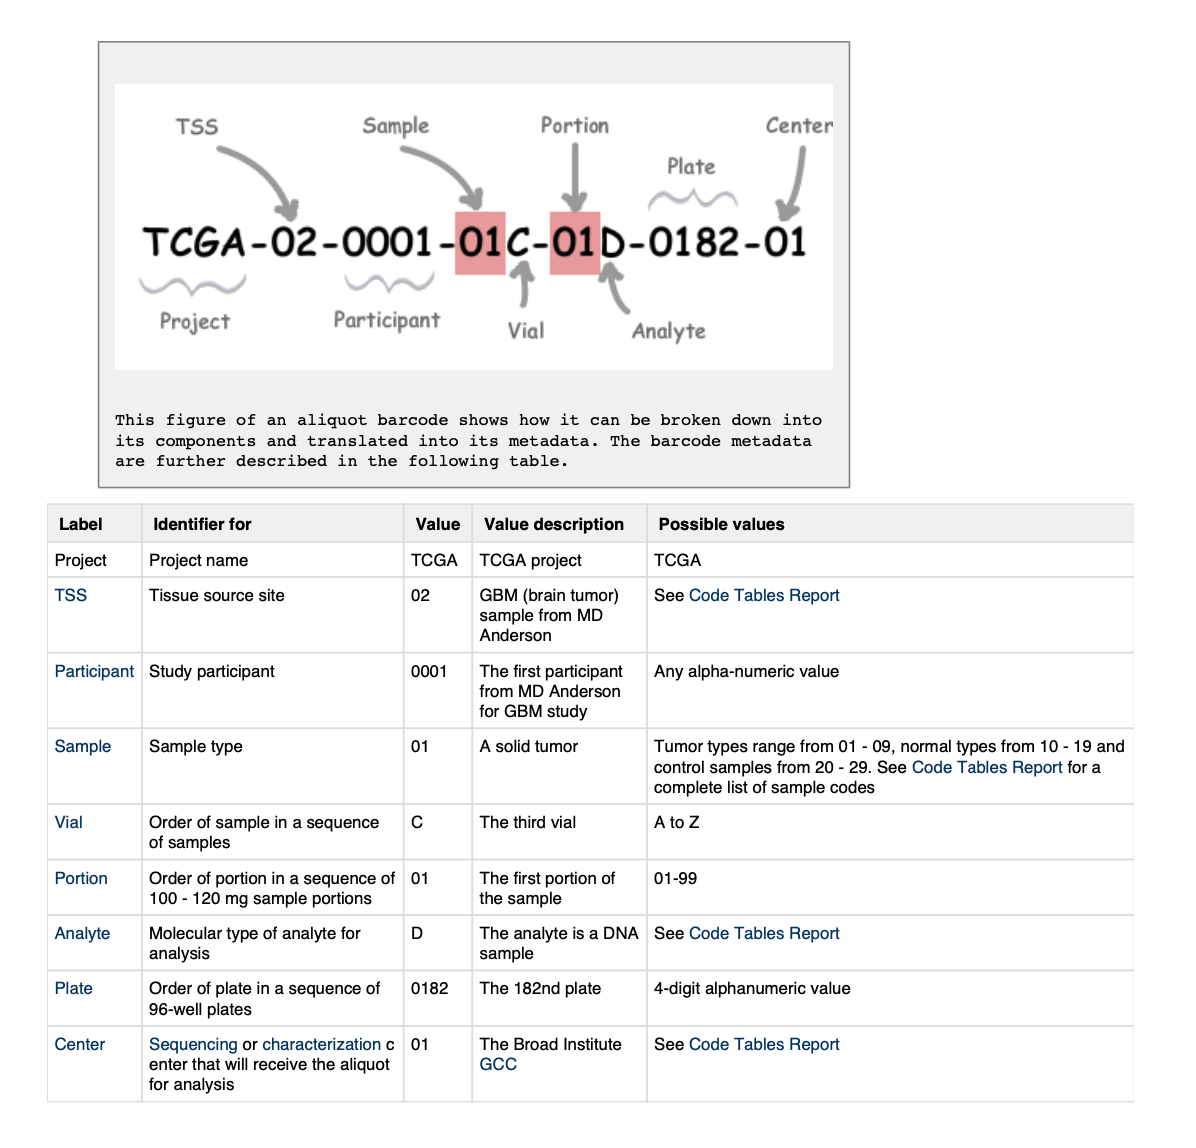

In [15]:
#The TCGA ID of column zero is made up of the following portions: 
from IPython.display import Image
Image(image_path)

In [16]:
data_genes_TCGA["PatientID_1"]= data_genes_TCGA.insert(0,'Patient_ID',data_genes_TCGA[0].astype(str).str[0:12])

In [17]:
data_genes_TCGA = data_genes_TCGA.drop("PatientID_1",axis=1)

In [18]:
#Time to Merge in the Patient Data: 
Patient_Info = pd.read_csv(patient_info_testicular,sep="\t",header=None)
# 
# Patient_Info = Patient_Info.drop([0,2,3,4,7],axis=1)
Patient_Info = Patient_Info [[1,5,6,22,23,46,47,70,76,87]] #This is choosing the features to add from the metadata. Change if needed.
Patient_Info = Patient_Info.drop([0,1,2],axis=0)

Patient_Info.head()

#Below is are the features being kept:
#Patient ID, Race, Ethnicity, Tumor Status, Vital Status, AJCC Nodes Pathologic pn, AJCC Tumor Pathologic Pt
#,age at diagnosis, Gender,Tissue source site

,1,5,6,22,23,46,47,70,76,87
3,TCGA-2G-AAEW,WHITE,NOT HISPANIC OR LATINO,WITH TUMOR,Dead,N0,M0,31,MALE,Testes
4,TCGA-2G-AAEX,WHITE,NOT HISPANIC OR LATINO,TUMOR FREE,Alive,N0,M0,38,MALE,Testes
5,TCGA-2G-AAF1,ASIAN,NOT HISPANIC OR LATINO,TUMOR FREE,Alive,N0,M0,28,MALE,Testes
6,TCGA-2G-AAF4,WHITE,NOT HISPANIC OR LATINO,TUMOR FREE,Alive,N0,M0,30,MALE,Testes
7,TCGA-2G-AAF6,WHITE,NOT HISPANIC OR LATINO,TUMOR FREE,Alive,N0,M0,28,MALE,Testes


In [19]:
data_genes_TCGA_patient =  pd.merge(Patient_Info, data_genes_TCGA, right_on="Patient_ID", left_on=1,how='right')
data_genes_TCGA_patient = data_genes_TCGA_patient.drop([1],axis=1)

In [20]:
index = np.arange(start=0, stop=107, step=1)
index2 = [107,108]
index3 = np.arange(109,124,1)
indexi = np.concatenate((np.concatenate((index2, index)),index3))

data_genes_TCGA_patient = data_genes_TCGA_patient.reindex(indexi) 


In [21]:
data_genes_TCGA_patient = data_genes_TCGA_patient.reset_index()
data_genes_TCGA_patient.columns = range(data_genes_TCGA_patient.shape[1])

In [22]:
data_genes_TCGA_patient = data_genes_TCGA_patient.drop([0,1],axis=1)
testicular_cancer_db = data_genes_TCGA_patient

In [23]:
#Drop all patients for which there is no metadata. Reduces Patient size to 108
testicular_cancer_db = testicular_cancer_db.drop(np.arange(109,124,1),axis=0)

In [24]:
testicular_cancer_db.head()

,2,3,4,5,6,7,8,9,10,11,...,222,223,224,225,226,227,228,229,230,231
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,...,CHEK1,COG3,GUSP4,ERCC5,IGFR1,IRF1,JAK2,CDKN2A,PTPN11,CDK1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,...,Chk1_pS296-R-V,COG3-R-V,DUSP4-R-V,ERCC5-R-C,IGF1R_pY1135_Y1136-R-V,IRF-1-R-C,Jak2-R-V,p16_INK4a-R-V,SHP-2_pY542-R-C,CDK1_pY15-R-C
2,WHITE,NOT HISPANIC OR LATINO,WITH TUMOR,Dead,N0,M0,31,MALE,Testes,TCGA-2G-AAEW,...,0.0800928317499999,-0.28908724425,-0.35243072675,-0.0580790527500001,-0.17769509775,-0.01040692825,0.27357020775,-0.30725466725,-0.27246927925,0.0516381562500001
3,WHITE,NOT HISPANIC OR LATINO,TUMOR FREE,Alive,N0,M0,38,MALE,Testes,TCGA-2G-AAEX,...,0.0392209742500002,0.0070381522500001,-0.000397927250000096,0.10194073875,-0.10780766725,0.000397927250000069,0.20384876625,0.14295990525,-0.35432554075,-0.11833798825
4,ASIAN,NOT HISPANIC OR LATINO,TUMOR FREE,Alive,N0,M0,28,MALE,Testes,TCGA-2G-AAF1,...,-0.00837370124999992,9.20687500000072e-05,-0.17978097475,0.06084878825,0.01051641625,-0.04558900325,0.11982208375,-0.0116358882499998,-0.10584633625,0.25487037625


# Cervical Cancer Data Preperation: 

In [25]:
#How much patient data do we have? 
folder = folder_cervical
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print("Working with {0} Files".format(len(onlyfiles)))

Working with 173 Files


In [26]:
#Explore one data entry
data = pd.read_csv(folder + onlyfiles[1], sep="\t",header=None)
data.columns = ["Protein", "Protein_Expression"]
data.head()

,Protein,Protein_Expression
0,Sample REF,9F4623A9-D7C2-4EB5-8CA9-6F0C67828AEB
1,Composite Element REF,Protein Expression
2,14-3-3_beta-R-V,-0.0961422259999999
3,14-3-3_epsilon-M-C,0.0479013300000001
4,14-3-3_zeta-R-V,0.169819278


In [27]:
counter = 0
for names in onlyfiles: 
    if names == '.DS_Store':
        print("bad")
    else: 
        new_data = pd.read_csv(folder + names, sep="\t",header=None)
        new_data.columns = ["Protein", "Protein_Expression"]
        data= data.merge(new_data,left_on='Protein',right_on="Protein")
    counter = counter +1   

print(str(counter))
print("The shape of the data frame is: " + str(data.shape))

173
The shape of the data frame is: (221, 175)


In [28]:
data = data.drop(1,axis=0)
data = data.T

In [29]:
protein_annotations = pd.read_csv(proteint_annot_cervical, sep="\t",header=None)
protein_annotations = protein_annotations.drop(protein_annotations.columns[[1,3,4,5,6,7,8]],axis = 1)
protein_annotations = protein_annotations.T

In [30]:
data_with_genes =  pd.merge(protein_annotations.T, data.T, left_on=2, right_on='Protein')
data_with_genes = data_with_genes.T
data_with_genes = data_with_genes.drop("Protein", axis=0)

In [31]:
TCGA_Annot = pd.read_csv(TCGA_annot_cervical,sep="\t",header=None)
TCGA_Annot = TCGA_Annot[[4,9]]

In [32]:
data_genes_TCGA =  pd.merge(data_with_genes,TCGA_Annot , left_on=0, right_on=4,how='left')
data_genes_TCGA = data_genes_TCGA.drop_duplicates()

In [33]:
#Get all column names
cols = list(data_genes_TCGA)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('9_y')))
# use ix to reorder
data_genes_TCGA = data_genes_TCGA.loc[:, cols]
data_genes_TCGA = data_genes_TCGA.drop("4_y", axis=1)

In [34]:
#Final Reorganization Steps
data_genes_TCGA = data_genes_TCGA.reset_index()
data_genes_TCGA = data_genes_TCGA.drop(data_genes_TCGA.columns[[0]],axis = 1)
data_genes_TCGA.columns = range(data_genes_TCGA.shape[1])

In [35]:
data_genes_TCGA["PatientID_1"]= data_genes_TCGA.insert(0,'Patient_ID',data_genes_TCGA[0].astype(str).str[0:12])
data_genes_TCGA = data_genes_TCGA.drop("PatientID_1",axis=1)
data_genes_TCGA.head()

,Patient_ID,0,1,2,3,4,5,6,7,8,...,211,212,213,214,215,216,217,218,219,220
0,nan,NaN,Gene Name,YWHAB,YWHAE,YWHAZ,EIF4EBP1,EIF4EBP1,EIF4EBP1,EIF4EBP1,...,CHEK1,COG3,GUSP4,ERCC5,IGFR1,IRF1,JAK2,CDKN2A,PTPN11,CDK1
1,nan,NaN,Sample REF,14-3-3_beta-R-V,14-3-3_epsilon-M-C,14-3-3_zeta-R-V,4E-BP1-R-V,4E-BP1_pS65-R-V,4E-BP1_pT37_T46-R-V,4E-BP1_pT70-R-V,...,Chk1_pS296-R-V,COG3-R-V,DUSP4-R-V,ERCC5-R-C,IGF1R_pY1135_Y1136-R-V,IRF-1-R-C,Jak2-R-V,p16_INK4a-R-V,SHP-2_pY542-R-C,CDK1_pY15-R-C
2,TCGA-IR-A3LK,TCGA-IR-A3LK-01A-21-A40I-20.P,9F4623A9-D7C2-4EB5-8CA9-6F0C67828AEB,-0.0961422259999999,0.0479013300000001,0.169819278,-0.075831038,0.038788279,-1.127755122,-0.198689621,...,-0.00122411699999997,0.039628302,0.0490967589999999,0.110302646,0.0508761200000001,0.03616566,0.218577961,0.293310549,-0.136349382,-0.268227368
3,TCGA-HG-A9SC,TCGA-HG-A9SC-01A-11-A40I-20.P,6F7ABE28-0E7B-48F7-9713-F18E9D295340,0.312821002,0.155283895,2.065443593,0.612668201,0.0691699790000002,-0.389325492,0.723970018,...,0.652668032,-1.151127237,0.664127639,1.091521267,0.624802454,1.010854939,-0.288773081,0.693003233,-0.554225848,-0.0282948159999998
4,TCGA-MY-A913,TCGA-MY-A913-01A-21-A40H-20.P,263D2292-E1D0-4937-90C2-C733495AFF02,0.0991454460000001,-0.173895199,0.157127898,-0.125666103,0.403258985,0.344101951,0.00911584700000001,...,-0.020927656,-0.138491186,0.685017796,0.159698137,0.030697672,-0.441736308,-0.123092341,0.449807231,0.69125433,0.519572406


In [36]:
#Time to Merge in the Patient Data: 
Patient_Info = pd.read_csv(patient_info_cervical,sep="\t",header=None) 
Patient_Info = Patient_Info [[1,6,10,14,25,52,63,67,84,143]]
Patient_Info = Patient_Info.drop([1,2],axis=0)
Patient_Info.head()

# Selecting: 
#gender,race, vital_status, tumor_status, age_at_diagnosis, tumor_grade, ajcc_nodes_pathologic_pn
#ajcc_tumor_pathologic_pt, tissue_source_site

,1,6,10,14,25,52,63,67,84,143
0,bcr_patient_barcode,gender,race,vital_status,tumor_status,age_at_diagnosis,tumor_grade,ajcc_nodes_pathologic_pn,ajcc_tumor_pathologic_pt,tissue_source_site
3,TCGA-2W-A8YY,FEMALE,WHITE,Alive,TUMOR FREE,51,G3,N0,T2a2,2W
4,TCGA-4J-AA1J,FEMALE,WHITE,Alive,TUMOR FREE,31,G3,N0,T1b2,4J
5,TCGA-BI-A0VR,FEMALE,WHITE,Alive,TUMOR FREE,53,G3,N1,T2b,BI
6,TCGA-BI-A0VS,FEMALE,WHITE,Alive,TUMOR FREE,48,G3,N0,T1b1,BI


In [37]:
data_genes_TCGA_patient =  pd.merge(Patient_Info, data_genes_TCGA, right_on="Patient_ID", left_on=1,how='right')
data_genes_TCGA_patient = data_genes_TCGA_patient.drop([1],axis=1)

In [38]:
index = np.arange(start=0, stop=173, step=1)
index2 = [173,174]
index3 = np.arange(174,175,1)
indexi = np.concatenate((np.concatenate((index2, index)),index3))
data_genes_TCGA_patient = data_genes_TCGA_patient.reindex(indexi) 


In [39]:
data_genes_TCGA_patient = data_genes_TCGA_patient.reset_index()
data_genes_TCGA_patient.columns = range(data_genes_TCGA_patient.shape[1])
data_genes_TCGA_patient.head()

,0,1,2,3,4,5,6,7,8,9,...,223,224,225,226,227,228,229,230,231,232
0,173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,CHEK1,COG3,GUSP4,ERCC5,IGFR1,IRF1,JAK2,CDKN2A,PTPN11,CDK1
1,174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Chk1_pS296-R-V,COG3-R-V,DUSP4-R-V,ERCC5-R-C,IGF1R_pY1135_Y1136-R-V,IRF-1-R-C,Jak2-R-V,p16_INK4a-R-V,SHP-2_pY542-R-C,CDK1_pY15-R-C
2,0,TCGA-2W-A8YY,FEMALE,WHITE,Alive,TUMOR FREE,51,G3,N0,T2a2,...,0.838128249,-1.204358576,0.98026583,0.576061552,0.742962649,0.280943847,-0.427620815,-1.555734871,-0.519747159,-0.0442280939999999
3,1,TCGA-4J-AA1J,FEMALE,WHITE,Alive,TUMOR FREE,31,G3,N0,T1b2,...,0.0805494759999999,-0.253046523,0.942242258,-0.114616487,0.016992148,-0.434624842,-0.144857264,0.507210703,-0.140891075,-0.499351567
4,2,TCGA-C5-A0TN,FEMALE,BLACK OR AFRICAN AMERICAN,Dead,WITH TUMOR,21,G3,N1,T1b,...,0.263113133,-0.733918136,0.745076229,0.0438304549999999,0.416370827,-0.130751658,-0.765478521,-0.140173625,-0.269787991,-0.582786817


In [40]:
data_genes_TCGA_patient = data_genes_TCGA_patient.drop([0,1],axis=1)
cervical_cancer_db = data_genes_TCGA_patient
cervical_cancer_db = cervical_cancer_db.drop([175],axis=0)

In [41]:
#Wahoo. Now ready for the SVD
cervical_cancer_db.head()

,2,3,4,5,6,7,8,9,10,11,...,223,224,225,226,227,228,229,230,231,232
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,...,CHEK1,COG3,GUSP4,ERCC5,IGFR1,IRF1,JAK2,CDKN2A,PTPN11,CDK1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,...,Chk1_pS296-R-V,COG3-R-V,DUSP4-R-V,ERCC5-R-C,IGF1R_pY1135_Y1136-R-V,IRF-1-R-C,Jak2-R-V,p16_INK4a-R-V,SHP-2_pY542-R-C,CDK1_pY15-R-C
2,FEMALE,WHITE,Alive,TUMOR FREE,51,G3,N0,T2a2,2W,TCGA-2W-A8YY,...,0.838128249,-1.204358576,0.98026583,0.576061552,0.742962649,0.280943847,-0.427620815,-1.555734871,-0.519747159,-0.0442280939999999
3,FEMALE,WHITE,Alive,TUMOR FREE,31,G3,N0,T1b2,4J,TCGA-4J-AA1J,...,0.0805494759999999,-0.253046523,0.942242258,-0.114616487,0.016992148,-0.434624842,-0.144857264,0.507210703,-0.140891075,-0.499351567
4,FEMALE,BLACK OR AFRICAN AMERICAN,Dead,WITH TUMOR,21,G3,N1,T1b,C5,TCGA-C5-A0TN,...,0.263113133,-0.733918136,0.745076229,0.0438304549999999,0.416370827,-0.130751658,-0.765478521,-0.140173625,-0.269787991,-0.582786817


In [42]:
#Adding features from patient side (BASIC) is finished

#Next: Solve the missing proteing problem

#Decide which features we are gonna try to group, then run SVD and see if we can quantify any results. 
#Furthermore, need some basis, to prove the data is normal. perhaps find a protein which typically overexpressed
#In both types of cancer or in males and females. If that doesn't work....unsure. 

#I've removed all data for which we don't have any metadata shrinking the number of males. Females have more
#patchy data. Will have to remove on a case by case basis. 

## SVD:  

In [43]:
#Select the expression values only: 
cerv_data = cervical_cancer_db.iloc[2:,12:]
tes_data = testicular_cancer_db.iloc[2:,12:]

#Convert to numpy array 
cerv_array = cerv_data.values
tes_array = tes_data.values

In [44]:
print("The shape of is " + str(cerv_array.shape))
print("Total number of cervical patients: " + str(cerv_array.shape[0]))
print("Total number of cervical features: " + str(cerv_array.shape[1]))

print()
print("The shape of is " + str(tes_array.shape))
print("Total number of testicular patients: " + str(tes_array.shape[0]))
print("Total number of testicular features: " + str(tes_array.shape[1]))

The shape of is (173, 219)
Total number of cervical patients: 173
Total number of cervical features: 219

The shape of is (107, 218)
Total number of testicular patients: 107
Total number of testicular features: 218


In [45]:
#Questions to answer: find the missing protein causing the difference in length

#Testicular appears to have 218 genes
#Ovarian appears to have 219 genes BOTH CONFIRMED FROM ORIGINAL DATA

In [46]:
cerv_array

array([['0.879446109', '0.283619534', '0.795979302', ..., '-1.555734871',
        '-0.519747159', '-0.0442280939999999'],
       ['0.153368761', '-0.11355863', '0.258062906', ..., '0.507210703',
        '-0.140891075', '-0.499351567'],
       ['0.123183488', '-0.03426341', '0.313855226', ..., '-0.140173625',
        '-0.269787991', '-0.582786817'],
       ...,
       ['1.154726379', '-0.622469291', '0.31579234', ..., '-0.368411531',
        '2.189381174', '-0.696829229'],
       ['0.140824075', '0.199997195', '0.353947477', ..., '-0.140014159',
        '0.337417984', '-0.0624450320000001'],
       ['-0.260754296', '-0.331246859', '-0.162688343', ...,
        '0.190780213', '0.239166302', '-0.00232083200000011']],
      dtype=object)

In [47]:
#Object Arrays are causing an issue. This comes from the mixed data types from the pandas matrix
cerv_test = np.array(list(cerv_array[:, :]), dtype=np.float)
tes_test = np.array(list(tes_array[:, :]), dtype=np.float)

In [48]:
U_cerv,sigma_cerv,VT_cerv = svd(cerv_test,full_matrices=False)
U_tes,sigma_tes,VT_tes = svd(tes_test,full_matrices=False)

In [49]:
print("Shape of U cervical " + str(U_cerv.shape))
sigma_cerv = np.diag(sigma_cerv) 
print("Shape of Sigma cervical" + str(sigma_cerv.shape))
print("Shape of VT cervical" + str(VT_cerv.shape))

print("\nShape of U testicular " + str(U_tes.shape))
sigma_tes = np.diag(sigma_tes) 
print("Shape of Sigma testicular" + str(sigma_tes.shape))
print("Shape of VT testicular" + str(VT_tes.shape))

Shape of U cervical (173, 173)
Shape of Sigma cervical(173, 173)
Shape of VT cervical(173, 219)

Shape of U testicular (107, 107)
Shape of Sigma testicular(107, 107)
Shape of VT testicular(107, 218)


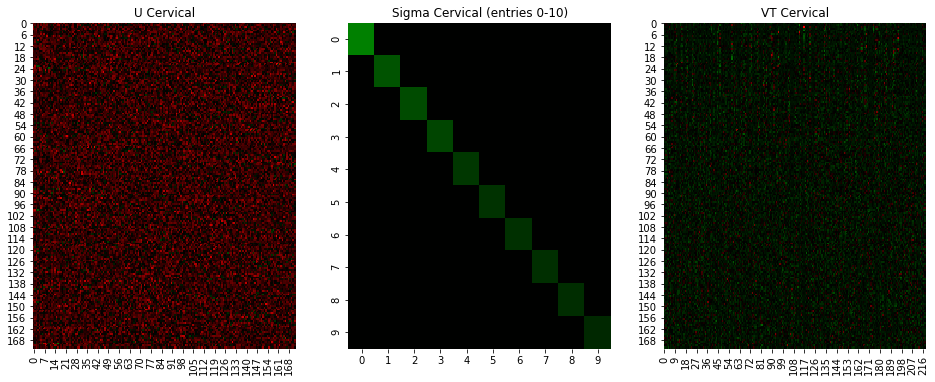

In [50]:
#Let's Visualize Heatmaps....
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,nrows=1)
fig.subplots_adjust(wspace=0.2)
fig.set_size_inches(16, 6)
ax1.set_title('U Cervical')
ax2.set_title('Sigma Cervical (entries 0-10)')
ax3.set_title('VT Cervical')
 
sns.heatmap(U_cerv, cmap=cmap, ax=ax1, cbar=False)
sns.heatmap(sigma_cerv[0:10,0:10], cmap=cmap, ax=ax2, cbar=False, center = 0)
sns.heatmap(VT_cerv, cmap=cmap, ax=ax3, cbar=False)

plt.show()

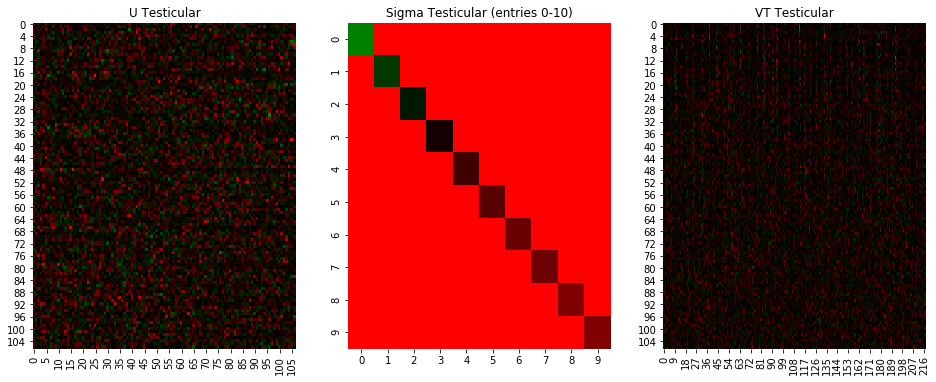

In [51]:
#Let's Visualize Heatmaps....
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,nrows=1)
fig.subplots_adjust(wspace=0.2)
fig.set_size_inches(16, 6)
ax1.set_title('U Testicular')
ax2.set_title('Sigma Testicular (entries 0-10)')
ax3.set_title('VT Testicular')
 
sns.heatmap(U_tes, cmap=cmap, ax=ax1, cbar=False)
sns.heatmap(sigma_tes[0:10,0:10], cmap=cmap, ax=ax2, cbar=False)
sns.heatmap(VT_tes, cmap=cmap, ax=ax3, cbar=False)

plt.show()

In [52]:
#Alright. Time to go back to the dataframes. Let's add all the metadata that I think might effect something. 
#Then from each of those arrays, I will organize the data from those points. 

# Data Organization: Vital Status

In [53]:
#Let's try sorting on vital status first: For test: C5 For cerv: C4

In [54]:
#Sorting the data based upon their vital status
cerv_sort = cervical_cancer_db.sort_values(4)
test_sort = testicular_cancer_db.sort_values(5)

In [55]:
#Select the expression values only: 
cerv_sort = cerv_sort.iloc[:-2,12:]
tes_sort = test_sort.iloc[:-2,12:]

#Convert to numpy array 
cerv_sort_array = cerv_sort.values
tes_sort_array = tes_sort.values

#Object Arrays are causing an issue. This comes from the mixed data types from the pandas matrix
cerv_sort_array = np.array(list(cerv_sort_array[:, :]), dtype=np.float)
tes_sort_array = np.array(list(tes_sort_array[:, :]), dtype=np.float)

In [56]:
#Run the SVD

U_cerv,sigma_cerv,VT_cerv = svd(cerv_sort_array.T,full_matrices=False)
U_tes,sigma_tes,VT_tes = svd(tes_sort_array.T,full_matrices=False)

#Let's take a peep at this data
print("Shape of U cervical " + str(U_cerv.shape))
sigma_cerv = np.diag(sigma_cerv) 
print("Shape of Sigma cervical" + str(sigma_cerv.shape))
print("Shape of VT cervical" + str(VT_cerv.shape))

print("\nShape of U testicular " + str(U_tes.shape))
sigma_tes = np.diag(sigma_tes) 
print("Shape of Sigma testicular" + str(sigma_tes.shape))
print("Shape of VT testicular" + str(VT_tes.shape))

Shape of U cervical (219, 173)
Shape of Sigma cervical(173, 173)
Shape of VT cervical(173, 173)

Shape of U testicular (218, 107)
Shape of Sigma testicular(107, 107)
Shape of VT testicular(107, 107)


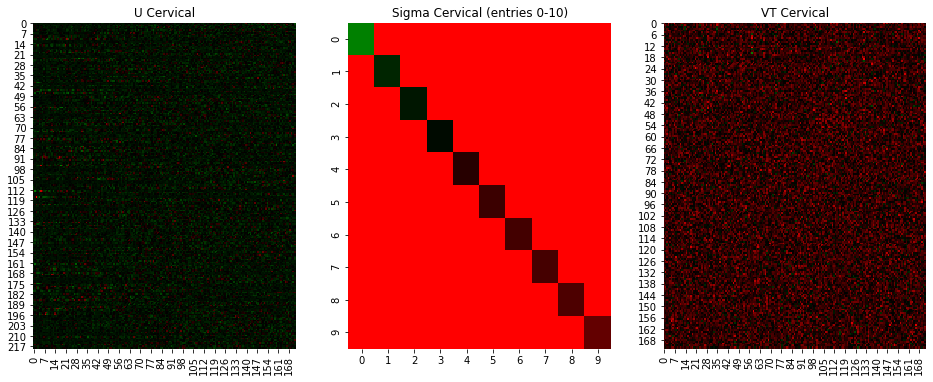

In [57]:
#Let's Visualize Heatmaps....
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,nrows=1)
fig.subplots_adjust(wspace=0.2)
fig.set_size_inches(16, 6)
ax1.set_title('U Cervical')
ax2.set_title('Sigma Cervical (entries 0-10)')
ax3.set_title('VT Cervical')
 
sns.heatmap(U_cerv, cmap=cmap, ax=ax1, cbar=False)
sns.heatmap(sigma_cerv[0:10,0:10], cmap=cmap, ax=ax2, cbar=False)
sns.heatmap(VT_cerv, cmap=cmap, ax=ax3, cbar=False)

plt.show()

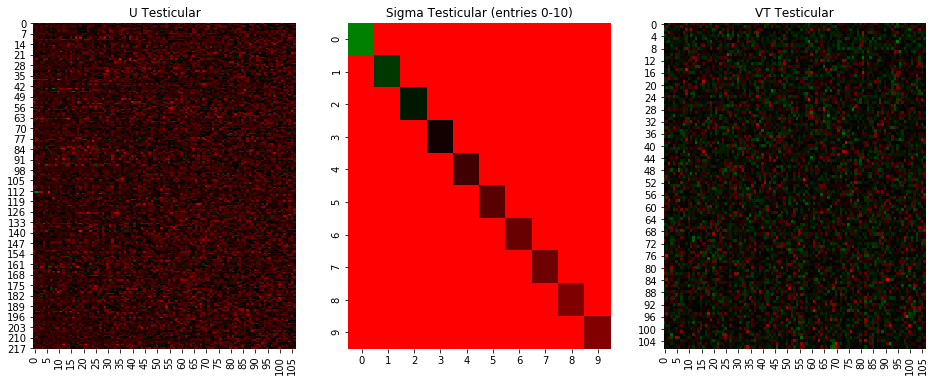

In [58]:
#Let's Visualize Heatmaps....
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,nrows=1)
fig.subplots_adjust(wspace=0.2)
fig.set_size_inches(16, 6)
ax1.set_title('U Testicular')
ax2.set_title('Sigma Testicular (entries 0-10)')
ax3.set_title('VT Testicular')
 
sns.heatmap(U_tes, cmap=cmap, ax=ax1, cbar=False)
sns.heatmap(sigma_tes[0:10,0:10], cmap=cmap, ax=ax2, cbar=False)
sns.heatmap(VT_tes, cmap=cmap, ax=ax3, cbar=False)

plt.show()

In [59]:
#Alright Cool. This organization and graphic wasn't too bad. 

# Data Organization: Age

In [60]:
#Sorting the data based upon their vital status
cerv_sort = cervical_cancer_db.sort_values(6)
test_sort = testicular_cancer_db.sort_values(8)

In [61]:
#Select the expression values only: 
cerv_sort = cerv_sort.iloc[:-2,12:]
tes_sort = test_sort.iloc[:-2,12:]

#Convert to numpy array 
cerv_sort_array = cerv_sort.values
tes_sort_array = tes_sort.values

#Object Arrays are causing an issue. This comes from the mixed data types from the pandas matrix
cerv_sort_age_array = np.array(list(cerv_sort_array[:, :]), dtype=np.float)
tes_sort_age_array = np.array(list(tes_sort_array[:, :]), dtype=np.float)


In [62]:
#Run the SVD

U_cerv_age,sigma_cerv_age,VT_cerv_age = svd(cerv_sort_age_array.T,full_matrices=False)
U_tes_age,sigma_tes_age,VT_tes_age = svd(tes_sort_age_array.T,full_matrices=False)

#Let's take a peep at this data
print("Shape of U cervical " + str(U_cerv_age.shape))
sigma_cerv_age = np.diag(sigma_cerv_age) 
print("Shape of Sigma cervical" + str(sigma_cerv_age.shape))
print("Shape of VT cervical" + str(VT_cerv_age.shape))

print("\nShape of U testicular " + str(U_tes_age.shape))
sigma_tes_age = np.diag(sigma_tes_age) 
print("Shape of Sigma testicular" + str(sigma_tes_age.shape))
print("Shape of VT testicular" + str(VT_tes_age.shape))

Shape of U cervical (219, 173)
Shape of Sigma cervical(173, 173)
Shape of VT cervical(173, 173)

Shape of U testicular (218, 107)
Shape of Sigma testicular(107, 107)
Shape of VT testicular(107, 107)


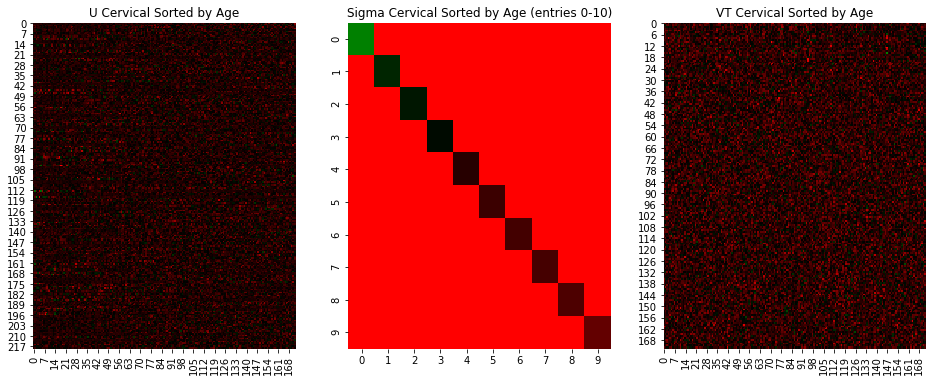

In [63]:
#Let's Visualize Heatmaps....
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,nrows=1)
fig.subplots_adjust(wspace=0.2)
fig.set_size_inches(16, 6)
ax1.set_title('U Cervical Sorted by Age')
ax2.set_title('Sigma Cervical Sorted by Age (entries 0-10)')
ax3.set_title('VT Cervical Sorted by Age')
 
sns.heatmap(U_cerv_age, cmap=cmap, ax=ax1, cbar=False)
sns.heatmap(sigma_cerv_age[0:10,0:10], cmap=cmap, ax=ax2, cbar=False)
sns.heatmap(VT_cerv_age, cmap=cmap, ax=ax3, cbar=False)

plt.show()

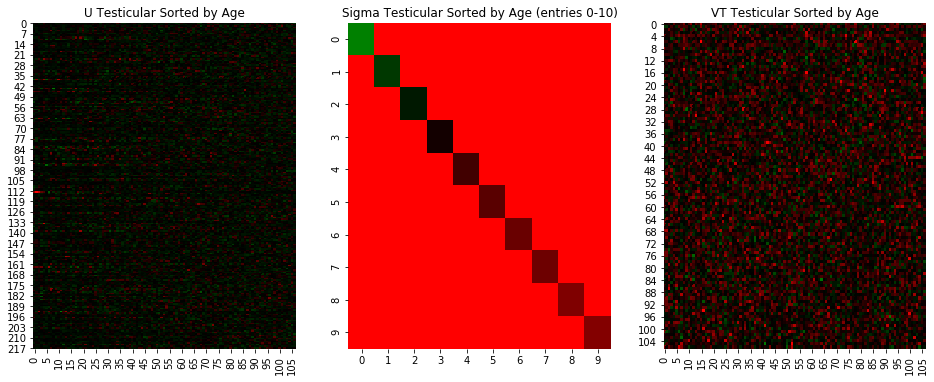

In [64]:
#Let's Visualize Heatmaps....
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,nrows=1)
fig.subplots_adjust(wspace=0.2)
fig.set_size_inches(16, 6)
ax1.set_title('U Testicular Sorted by Age')
ax2.set_title('Sigma Testicular Sorted by Age (entries 0-10)')
ax3.set_title('VT Testicular Sorted by Age')
 
sns.heatmap(U_tes_age, cmap=cmap, ax=ax1, cbar=False)
sns.heatmap(sigma_tes_age[0:10,0:10], cmap=cmap, ax=ax2, cbar=False)
sns.heatmap(VT_tes_age, cmap=cmap, ax=ax3, cbar=False)

plt.show()

# Concatenate the test. and Cerv. on genes

In [65]:
cervical_cancer_db.iloc[0,49]
#Testicular DOES NOT HAVE BRCA2 time to delete from the current data...
#Drop BRCA2 from Cervical Cancer
cervical_cancer_db_noBRCA2 = cervical_cancer_db.drop(51,axis=1)

In [66]:
#Need Patient Features in the same order: 

#[CERVICAL] gender,race, vital_status, tumor_status, age_at_diagnosis, tumor_grade, ajcc_nodes_pathologic_pn
#ajcc_tumor_pathologic_pt, tissue_source_site

#[Testicular]#Race, Ethnicity, Tumor Status, Vital Status, AJCC Nodes Pathologic pn, AJCC Tumor Pathologic Pt
#,age at diagnosis, Gender,Tissue source site


In [67]:
#Alligning patient features: Order 
#Race, Tumor Status, Vital Status, AJCC Nodes Pathologic pn, AJCC Tumor Pathologic Pt
#,age at diagnosis, Gender,Tissue source site, Patient ID

cols = list(cervical_cancer_db_noBRCA2.columns.values)
cols = [3,5,4,8,9,6,2,10] + cols[9:]
cervical_cancer_db_noBRCA2 = cervical_cancer_db_noBRCA2.reindex(columns = cols)
testicular_cancer_db_BRCA2match = testicular_cancer_db.drop(3,axis = 1)

In [68]:
print("Cervical Cancer Data Shape: " + str(cervical_cancer_db_noBRCA2.shape))
print("Testicular Cancer Data Shape: " + str(testicular_cancer_db_BRCA2match.shape))
print("Where Patients rows and attributes then genes are columns")

Cervical Cancer Data Shape: (175, 229)
Testicular Cancer Data Shape: (109, 229)
Where Patients rows and attributes then genes are columns


In [69]:
#Reset the Index
cervical_cancer_db_noBRCA2 = cervical_cancer_db_noBRCA2.reset_index()
cervical_cancer_db_noBRCA2 = cervical_cancer_db_noBRCA2.drop(cervical_cancer_db_noBRCA2.columns[[0]],axis = 1)
cervical_cancer_db_noBRCA2.columns = range(cervical_cancer_db_noBRCA2.shape[1])

testicular_cancer_db_BRCA2match = testicular_cancer_db_BRCA2match.reset_index()
testicular_cancer_db_BRCA2match = testicular_cancer_db_BRCA2match.drop(testicular_cancer_db_BRCA2match.columns[[0]],axis = 1)
testicular_cancer_db_BRCA2match.columns = range(testicular_cancer_db_BRCA2match.shape[1])

In [70]:
#Concatenate!
comb_cerv_test = pd.concat([cervical_cancer_db_noBRCA2,testicular_cancer_db_BRCA2match.iloc[2:,:]], axis=0)
comb_cerv_test.shape

(282, 229)

In [71]:
#Reset the Index
comb_cerv_test = comb_cerv_test.reset_index()
comb_cerv_test = comb_cerv_test.drop(comb_cerv_test.columns[[0]],axis = 1)
comb_cerv_test.columns = range(comb_cerv_test.shape[1])
comb_cerv_test.head()

,0,1,2,3,4,5,6,7,8,9,...,219,220,221,222,223,224,225,226,227,228
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,...,CHEK1,COG3,GUSP4,ERCC5,IGFR1,IRF1,JAK2,CDKN2A,PTPN11,CDK1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,...,Chk1_pS296-R-V,COG3-R-V,DUSP4-R-V,ERCC5-R-C,IGF1R_pY1135_Y1136-R-V,IRF-1-R-C,Jak2-R-V,p16_INK4a-R-V,SHP-2_pY542-R-C,CDK1_pY15-R-C
2,WHITE,TUMOR FREE,Alive,N0,T2a2,51,FEMALE,2W,TCGA-2W-A8YY,TCGA-2W-A8YY-01A-21-A40H-20.P,...,0.838128249,-1.204358576,0.98026583,0.576061552,0.742962649,0.280943847,-0.427620815,-1.555734871,-0.519747159,-0.0442280939999999
3,WHITE,TUMOR FREE,Alive,N0,T1b2,31,FEMALE,4J,TCGA-4J-AA1J,TCGA-4J-AA1J-01A-11-A40H-20.P,...,0.0805494759999999,-0.253046523,0.942242258,-0.114616487,0.016992148,-0.434624842,-0.144857264,0.507210703,-0.140891075,-0.499351567
4,BLACK OR AFRICAN AMERICAN,WITH TUMOR,Dead,N1,T1b,21,FEMALE,C5,TCGA-C5-A0TN,TCGA-C5-A0TN-01A-11-A40H-20.P,...,0.263113133,-0.733918136,0.745076229,0.0438304549999999,0.416370827,-0.130751658,-0.765478521,-0.140173625,-0.269787991,-0.582786817


In [72]:
comb_cerv_test.iloc[170:180,:]

,0,1,2,3,4,5,6,7,8,9,...,219,220,221,222,223,224,225,226,227,228
170,WHITE,[Unknown],Alive,N0,T1b2,42,FEMALE,ZJ,TCGA-ZJ-AAXB,TCGA-ZJ-AAXB-01A-21-A40J-20.P,...,0.0782943539999998,-0.123271271,0.394582132,0.0904841229999999,-0.181777187,-0.231853499,0.19776415,-0.0141899080000001,0.0448074119999999,0.141787456
171,[Unknown],[Unknown],Alive,N0,T3b,35,FEMALE,ZJ,TCGA-ZJ-AAXD,TCGA-ZJ-AAXD-01A-11-A40J-20.P,...,0.036088052,0.024450753,-0.280861602,0.040107366,-0.02506264,-0.054829395,0.047413761,-0.232732602,0.324369878,-0.117539173
172,[Unknown],[Unknown],Alive,N0,T2b,62,FEMALE,ZJ,TCGA-ZJ-AAXF,TCGA-ZJ-AAXF-01A-41-A40J-20.P,...,-1.251061404,-0.692358629,0.152787783,-0.324477465,0.703898564,-0.0988040670000006,-0.415680169,-0.368411531,2.189381174,-0.696829229
173,WHITE,[Unknown],Alive,N1,T1b2,34,FEMALE,ZJ,TCGA-ZJ-AAXN,TCGA-ZJ-AAXN-01A-21-A40I-20.P,...,0.154323828,-0.426151772,0.816422883,0.389808879,0.125462774,0.0887313190000001,-0.586948231,-0.140014159,0.337417984,-0.0624450320000001
174,WHITE,[Unknown],Alive,N1,T2b,25,FEMALE,ZJ,TCGA-ZJ-AB0I,TCGA-ZJ-AB0I-01A-21-A40J-20.P,...,-0.0423215700000001,-0.109722533,-0.0263510880000004,0.51070724,-0.277124965,0.248667739,0.204677688,0.190780213,0.239166302,-0.00232083200000011
175,WHITE,WITH TUMOR,Dead,N0,M0,31,MALE,Testes,TCGA-2G-AAEW,TCGA-2G-AAEW-01A-21-A45P-20.P,...,0.0800928317499999,-0.28908724425,-0.35243072675,-0.0580790527500001,-0.17769509775,-0.01040692825,0.27357020775,-0.30725466725,-0.27246927925,0.0516381562500001
176,WHITE,TUMOR FREE,Alive,N0,M0,38,MALE,Testes,TCGA-2G-AAEX,TCGA-2G-AAEX-01A-21-A45P-20.P,...,0.0392209742500002,0.0070381522500001,-0.000397927250000096,0.10194073875,-0.10780766725,0.000397927250000069,0.20384876625,0.14295990525,-0.35432554075,-0.11833798825
177,ASIAN,TUMOR FREE,Alive,N0,M0,28,MALE,Testes,TCGA-2G-AAF1,TCGA-2G-AAF1-01A-21-A45P-20.P,...,-0.00837370124999992,9.20687500000072e-05,-0.17978097475,0.06084878825,0.01051641625,-0.04558900325,0.11982208375,-0.0116358882499998,-0.10584633625,0.25487037625
178,WHITE,TUMOR FREE,Alive,N0,M0,30,MALE,Testes,TCGA-2G-AAF4,TCGA-2G-AAF4-01A-21-A45P-20.P,...,0.0906404089999999,-0.207975672,-0.2417589495,0.0850644545,-0.0532942815,0.136938346,0.298594222,0.103734935,-0.197518422,0.2786169985
179,WHITE,TUMOR FREE,Alive,N0,M0,28,MALE,Testes,TCGA-2G-AAF6,TCGA-2G-AAF6-01A-21-A45P-20.P,...,-0.0211812175,0.0367982315000001,-0.225314708,0.296988015,-0.123131899,0.1964860585,0.1579503145,0.1039093775,-0.4051213975,-0.51614954


In [73]:
#Select the expression values only: 
comb_cerv_test = comb_cerv_test.iloc[2:,11:]

#Convert to numpy array 
comb_cerv_test_array = comb_cerv_test.values

#Object Arrays are causing an issue. This comes from the mixed data types from the pandas matrix
comb_cerv_test_array = np.array(list(comb_cerv_test_array[:, :]), dtype=np.float)

In [74]:
#Time to run the SVD
#Run the SVD

U_comb,sigma_comb,VT_comb = svd(comb_cerv_test_array,full_matrices=False)


#Let's take a peep at this data
print("Shape of U cervical " + str(U_comb.shape))
sigma_comb = np.diag(sigma_comb) 
print("Shape of Sigma cervical" + str(sigma_comb.shape))
print("Shape of VT cervical" + str(VT_comb.shape))

print("we have 280 patients and 218 proteins")

Shape of U cervical (280, 218)
Shape of Sigma cervical(218, 218)
Shape of VT cervical(218, 218)
we have 280 patients and 218 proteins


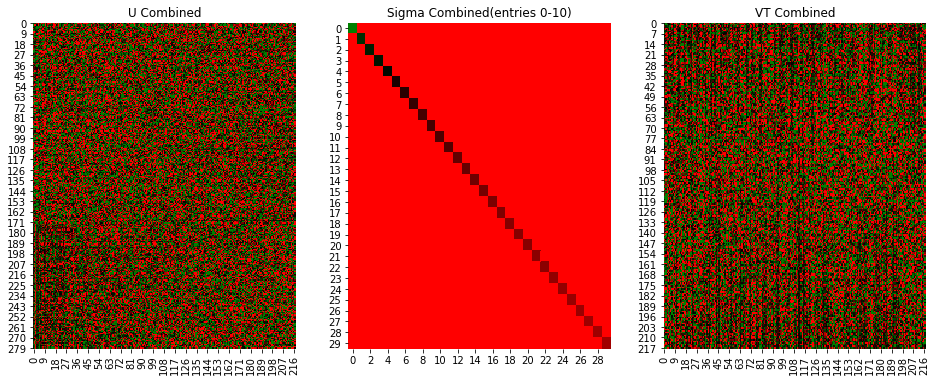

In [121]:
#Let's Visualize Heatmaps....
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,nrows=1)
fig.subplots_adjust(wspace=0.2)
fig.set_size_inches(16, 6)
ax1.set_title('U Combined')
ax2.set_title('Sigma Combined(entries 0-10)')
ax3.set_title('VT Combined')
 
sns.heatmap(U_comb, cmap = cmap,vmin = -0.05,vmax = 0.05, ax=ax1, cbar=False)
sns.heatmap(sigma_comb[0:30,0:30], cmap = cmap, ax=ax2, cbar=False)
sns.heatmap(VT_comb, cmap = cmap,vmin = -0.05,vmax = 0.05, ax=ax3, cbar=False)

plt.show()

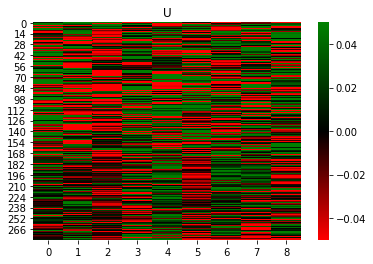

In [116]:
ax = sns.heatmap(U_comb[:,[6,9,10,13,17,18,19,20,24]],cmap = cmap,vmin = -0.05,vmax = 0.05)
plt.title("U")
plt.show()

In [123]:
#Boxplot on U...
#6,9,10,13,17,18,19,20,24
cerv_U  = U_comb[:172,26]
test_U = U_comb[173:,26]
print(stats.mannwhitneyu(cerv_U,test_U))

MannwhitneyuResult(statistic=7346.0, pvalue=0.0023165169788880117)

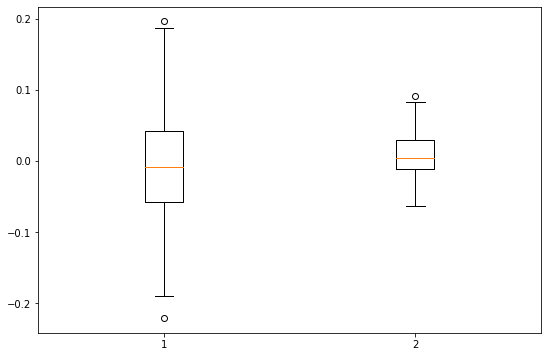

In [98]:
test = [cerv_U,test_U]

fig = plt.figure(1,(9,6))
ax = fig.add_subplot(111)
bp = ax.boxplot(test)
plt.show()

# Analyzing ESR1 Levels in Testicular vs. Cervical cancers

In [79]:
#ESR1 is Estrogen receptor 1. We would expect that expression would be (on average) higher for Cervical Cancer

#Approach: First find the location of the estrogen data.Place the data into an array. Then plot against the testicular d
#data in a boxplot

In [80]:
testicular_cancer_db.iloc[0,84]

'ESR1'

In [81]:
ESR1_cervical_protein_level_U = cerv_sort_age_array[:,73]
ESR1_testicular_protein_level_U = tes_sort_age_array[:,72]
ESR1_Data = [ESR1_cervical_protein_level_U,ESR1_testicular_protein_level_U]\

ESR1_testicular_protein_level_U.max()

0.759729797

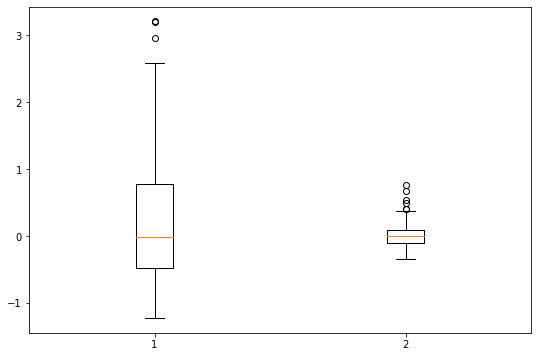

In [82]:
fig = plt.figure(1,(9,6))
ax = fig.add_subplot(111)
bp = ax.boxplot(ESR1_Data)
plt.show()

In [83]:
from scipy import stats
stats.ttest_ind(ESR1_cervical_protein_level_U,ESR1_testicular_protein_level_U)

# This shows there is significant difference in expression level of ESR1 between the two types of cancer.

Ttest_indResult(statistic=1.9867881037641155, pvalue=0.04792738279840995)

In [84]:
ESR1_cervical_protein_level_U = U_cerv_age[74,:]
ESR1_testicular_protein_level_U = U_tes_age[73,:]
ESR1_Data = [ESR1_cervical_protein_level_U,ESR1_testicular_protein_level_U]

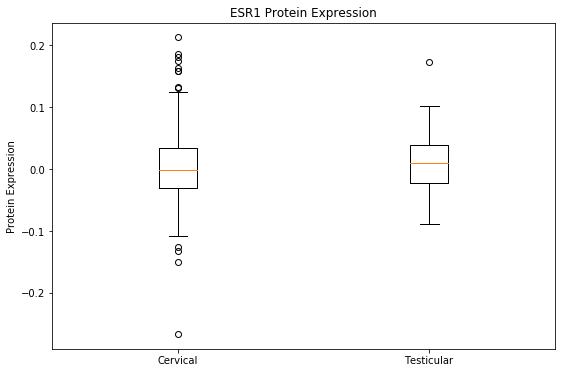

In [85]:
fig = plt.figure(1,(9,6))
ax = fig.add_subplot(111)
bp = ax.boxplot(ESR1_Data)


plt.xticks((1,2),('Cervical','Testicular'),color = 'k')
plt.ylabel("Protein Expression")
plt.title("ESR1 Protein Expression")

plt.show()

In [86]:
from scipy import stats

stats.ttest_ind(ESR1_cervical_protein_level_U,ESR1_testicular_protein_level_U)

Ttest_indResult(statistic=-0.5678798178809874, pvalue=0.5705749270388967)

# This is me overthinking stufff

In [87]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://cdn.britannica.com/18/66018-050-AA222E0F/Bruce-Lee-scene-Enter-the-Dragon-1973.jpg")